# 異なる視点からの転移学習が可能か確認
最終目標：  
9つある視点（高さ方向:3 x 水平方向:3）のうち、まずは特定の水平方向位置で高さ方向だけ変化させた場合で試し、その後水平方向も含めて変化させる。  
訓練データにはテストデータに含まれない視点を用いることに注意する。

## 今回の目標
水平方向位置を固定し、`lower`,`middle`,`upper`のうち2つを訓練データに、1つをテストデータにする  
半教師ありでするなら訓練データのものは映像全部をラベルなし訓練データに使う

In [2]:
import numpy as np
import pandas as pd
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from glob import glob

# Config

In [3]:
v_stat = ["lower", "middle", "upper"]
h_stat = ["side", "naname", "front"]

# Data Import

In [4]:
vp_type = "*"  # Viewpoint type

pict_dir = "../data/push-ups_2017-12-05/{}/pict/2-1.COCO-pose/".format(vp_type)
for f in glob(pict_dir):
    print(f)

print()    

movie_dir = "../data/push-ups_2017-12-05/{}/movie/2-1.COCO-pose/".format(vp_type)
for f in glob(movie_dir):
    print(f)
    
data_files = glob(pict_dir + "*.csv") + glob(movie_dir + "*.csv")

## データの選定 

In [5]:
def loadCSV(file):
    df = pd.read_csv(file, header=None, dtype=str)
    return df.values

def fillNan(file):
    df = pd.read_csv(file, header=None, dtype=str)
    idx = np.arange(55)
    idx[0], idx[-1] = 54, 0
    df[df.isnull().any(axis=1)] = df[df.isnull().any(axis=1)].iloc[:, idx]
    df = df.replace(np.nan, "0")
    return df.values

def loadAllData(csv_list, vs, hs, stats = ["_up", "_down", "movie"]):
    out = [{} for _ in range(2*len(stats))]
    for v in vs:
        for h in hs:
            pos = v + "_" + h
            filtered_csv_list = list(filter(lambda x: pos in x, csv_list))
            # print(filtered_csv_list)
            for i, s in enumerate(stats):
                arrays = [fillNan(f) for f in filtered_csv_list if s in f]
                if len(arrays) > 0:
                    tmp = np.vstack(arrays)
                    out[2*i][pos] = tmp[:, :-1].astype(float)
                    out[2*i + 1][pos] = tmp[:, -1].astype(str)
                else:
                    out[2*i][pos] = None
                    out[2*i + 1][pos] = None
#                 out[i][pos] = tmp
    return out
                
# def loadData(stat, pict, movie):
#     def getIntgData(which, dirs):
#         _dir = filter(lambda x: which in x, dirs)
#         out = np.vstack([loadCSV(d) for s in stat for d in _dir if s in d])
#         return out
#     up_data = getIntgData("_up", pict)
#     down_data = getIntgData("_down", pict)
#     movie_data = getIntgData("movie", movie)
#     return up_data, down_data, movie_data

In [6]:
up_data, up_names, down_data, down_names, movie_data, movie_names = loadAllData(data_files, v_stat, h_stat)

In [7]:
def chooseRL(data):
    '''
    data: data_num x 54
    '''
    if data is None:
        return np.zeros((1, 6))
        
    right = np.arange(2, 5)
    left = np.arange(5, 8)
    _data = data.reshape(-1, 18, 3)
    conf_r = _data[:, right, 2]  # n_data x 3
    conf_l = _data[:, left, 2]   # n_data x 3
    
    def isZeroInRow(tmp):
        # tmp: n_data x n_joint
        return np.any(tmp == 0, axis=1)

    right_bool, left_bool = np.zeros(18, dtype=bool), np.zeros(18, dtype=bool)
    right_bool[right] = True
    left_bool[left] = True
    rl_bool = (left_bool, right_bool)
    
    conf_0 = np.logical_xor(isZeroInRow(conf_r), isZeroInRow(conf_l))    # inclusion of zero for r&l matches
    conf_nonzero = isZeroInRow(conf_r) > isZeroInRow(conf_l)
    conf_val = (np.mean(conf_r, axis=1) > np.mean(conf_l, axis=1))  # mean conf for r is larger than l
    mask = np.zeros(_data.shape[:2], dtype=bool)
    # 左右どちらもconf=0の関節がある場合、どうせそのデータは削除されるので適当に選ぶ
    # 左右どちらもconf=0の関節がない場合、平均confが大きい方を選ぶ
    # これらはまとめて処理できる
    for i in range(data.shape[0]):
        if conf_0[i]:
            mask[i] = rl_bool[conf_val[i]]
        else:
            mask[i] = rl_bool[conf_nonzero[i]]

    pos = _data[mask, :2]
    out = pos.reshape(-1, 6)
    return out

def extractJointPos(data, index_list):
    return np.dstack([data[:, index_list*3], data[:, index_list*3+1]]).reshape(-1, 2*len(index_list))

def extractJointConf(data, index_list):
    return data[:, index_list*3+2]

def normalizePos(pos, all_data):
    '''
    Assuming...
    pos: n_data x (2*n_selected_joint); x, y, ...
    all_data: n_data x (3*n_all_joint); x, y, conf, ...
    '''
    if all_data is None:
        return np.zeros_like(pos)
    N, d = pos.shape
    N, D = all_data.shape
    pos = pos.reshape(N, d//2, 2)
    all_data = all_data.reshape(N, D//3, 3)[:, :, 0:2]
    xy_max = np.max(all_data, axis=1)[:, np.newaxis]
    xy_min = np.min(all_data, axis=1)[:, np.newaxis]
    out = (pos - xy_min)/(xy_max - xy_min)
    return out.reshape(N, d)

# def normalizePos(pos, all_data):
#     '''
#     Assuming...
#     pos: n_data x (2*n_selected_joint); x, y, ...
#     all_data: n_data x (3*n_all_joint); x, y, conf, ...
#     '''
#     rows, cols = pos.shape
#     all_rows, all_cols = all_data.shape
#     if all_cols % 3 != 0:
#         print("all_data needs 3*n cols")
#         return
#     x = all_data[:, range(0, 54, 3)]
#     y = all_data[:, range(1, 54, 3)]
#     conf = all_data[:, range(2, 54, 3)]
    
#     x_max = np.max(x, axis=1, keepdims=True)
#     x[conf < 0.05] = np.inf
#     x_min = np.min(x, axis=1, keepdims=True)
    
#     y_max = np.max(y, axis=1, keepdims=True)
#     y[conf < 0.05] = np.inf
#     y_min = np.min(y, axis=1, keepdims=True)
    
#     pos_max = np.tile(np.reshape(np.dstack([x_max, y_max]), (-1, 2)), (1, cols//2))
#     pos_min = np.tile(np.reshape(np.dstack([x_min, y_min]), (-1, 2)), (1, cols//2))
    
#     # return pos / (pos_max - pos_min)
#     return (pos - pos_min)/(pos_max - pos_min)

def getMaskForLowConf(pos):
    N, d = pos.shape
    mask = np.ones(N, dtype=bool)
    mask[np.any(pos == 0., axis=1)] = False
    return mask

def deleteLowConf(pos, data):
    '''
    data: data_num x (2*joint_num)
    '''
    mask = getMaskForLowConf(pos)
    return pos[mask], data[mask], mask

def makeFeature(pos):
    n, d = pos.shape
    d //= 2
    _pos = pos.reshape(n, d, 2)
    # カーネル行列を作る時に使うテクニックのテンソル版
    a = np.repeat(np.sum(_pos**2, axis=2)[:, :, np.newaxis], d, axis=2)
    b = np.transpose(a, (0, 2, 1))
    c = np.einsum("ijk,ilk->ijl", _pos, _pos)
    out = a - 2*c + b
    i1, i2 = np.triu_indices(d, k=1)
    out = out[np.repeat(np.arange(n), [d*(d-1)//2]), np.tile(i1, n), np.tile(i2, n)].reshape(n, d*(d-1)//2)
    return out

def mapdict(dic, func):
    if type(dic) == dict:
        return {k:func(v) for (k, v) in dic.items()}
    elif type(dic) in [list, tuple]:
        keys = dic[0].keys()
        return {k:func(*list(map(lambda x: x.get(k), dic))) for k in keys}

In [8]:
up_pos = mapdict(up_data, chooseRL)
up_mask = mapdict(up_pos, getMaskForLowConf)
down_pos = mapdict(down_data, chooseRL)
down_mask = mapdict(down_pos, getMaskForLowConf)
movie_pos = mapdict(movie_data, chooseRL)
movie_mask = mapdict(movie_pos, getMaskForLowConf)

In [9]:
# up_pos, up_data, up_mask = deleteLowConf(chooseRL(up_data), up_data)
# down_pos, down_data, down_mask = deleteLowConf(chooseRL(down_data), down_data)
# movie_pos, movie_data, movie_mask = deleteLowConf(chooseRL(movie_data), movie_data)

In [10]:
# right = np.arange(2, 5)
# (up_pos, up_data, up_mask), up_conf = deleteLowConf(extractJointPos(up_data, right), up_data), extractJointConf(up_data, right)
# (down_pos, down_data, down_mask), down_conf = deleteLowConf(extractJointPos(down_data, right), down_data), extractJointConf(down_data, right)
# (movie_pos, movie_data, movie_mask), movie_conf = deleteLowConf(extractJointPos(movie_data, right), movie_data), extractJointConf(movie_data, right)

__↓あとでmaskするのでRuntimeWarningが出ても問題ない__

In [11]:
nm_up_pos = mapdict([up_pos, up_data], normalizePos)
nm_down_pos = mapdict([down_pos, down_data], normalizePos)
nm_movie_pos = mapdict([movie_pos, movie_data], normalizePos)

In [12]:
# # 肩を原点にして特徴量にする
# nm_up_pos = nm_up_pos[:, 2:] - np.tile(nm_up_pos[:, :2], (1, 2))
# nm_down_pos = nm_down_pos[:, 2:] - np.tile(nm_down_pos[:, :2], (1, 2))
# nm_movie_pos = nm_movie_pos[:, 2:] - np.tile(nm_movie_pos[:, :2], (1, 2))

In [13]:
# 距離を特徴量にする
nm_up_pos = mapdict(nm_up_pos, makeFeature)
nm_down_pos = mapdict(nm_down_pos, makeFeature)
nm_movie_pos = mapdict(nm_movie_pos, makeFeature)

In [14]:
# nm_movie_names = movie_names[movie_mask]

# 半教師あり学習（新正規化）

くっつけてラベルも作る

| クラス | ラベル |
|:------|------:|
|up|1|
|down|0|
|unknown|-1|

やることは、
- テストデータが訓練データに含まれない場合に推定できるのか
- 全てのデータを訓練データにしたときに推定できるのか
- 高さ方向の自由度を`upper`と`lower`だけにする
- 同一水平位置で訓練データとテストデータを構築する。そしてテストデータの視点は訓練データから除く。

### 訓練データに含まれないテストデータに対してupかdownを推定
訓練データにはテストデータが含まれないようにする  
訓練データにラベルなしの動画を含めなかった

|テストデータ|推定結果|
|:---------|:-----:|
|`upper_side`|O|
|`upper_naname`|データなし|
|`upper_front`|O|
|`middle_side`|O|
|`middle_naname`|O|
|`middle_front`|O|
|`lower_side`|X|
|`lower_naname`|X|
|`lower_front`|X|

`lower`だけ推定がうまく行かなかった。撮影している時に`upper`と`middle`はほとんど同じ視点という話があったが、これが影響しているのでは？

### 全てのデータを訓練データにしたときに推定できるのか
訓練データにテストデータが含まれていても気にしない  
訓練データにラベルなしの動画を含めなかった

|テストデータ|推定結果|
|:---------|:-----:|
|`upper_side`|O|
|`upper_naname`|データなし|
|`upper_front`|O|
|`middle_side`|O|
|`middle_naname`|O|
|`middle_front`|O|
|`lower_side`|X|
|`lower_naname`|X|
|`lower_front`|O|

### 高さ二値
高さ方向の自由度をupperとlowerだけにして訓練データにテストデータを含めない  
訓練データにラベルなしの動画を含めなかった

|テストデータ|推定結果|
|:---------|:-----:|
|`upper_side`|O|
|`upper_naname`|データなし|
|`upper_front`|O|
|`lower_side`|X|
|`lower_naname`|X|
|`lower_front`|O|

### 同一水平位置で訓練データとテストデータを構築する。そしてテストデータの視点は訓練データから除く。
訓練データにラベルなしの動画を含めなかった

|水平位置|テストデータ|推定結果|
|:---------|:---------|:-----:|
|`side`|`lower`|X|
|`side`|`middle`|O|
|`naname`|`lower`|X|
|`naname`|`middle`|O|
|`front`|`lower`|^|
|`front`|`middle`|O|

In [15]:
# 任意の組み合わせ
# train_key = ["upper_side", "lower_side"]
# test_key = ["middle_side"]

# --------------------------------------------------------------------------------------------------

# 9つの視点の場合
# train_key = ["{}_{}".format(a, b) for a in ["upper", "middle", "lower"] for b in ["side", "naname", "front"]]

# --------------------------------------------------------------------------------------------------

# 6つの視点の場合
# train_key = ["{}_{}".format(a, b) for a in ["upper", "lower"] for b in ["side", "naname", "front"]]

# --------------------------------------------------------------------------------------------------

# 水平位置固定で高さ二値とし、2つの視点を訓練データ・テストデータに分ける
train_key = ["{}_{}".format(a, b) for a in ["lower", "middle"] for b in ["front"]]
# upper_nanameはmovie_dataがないのでテストデータとして使えない
test_key = ["middle_front"]
# テストの分を訓練データから消したかったらTrueにする
if True:
    for tk in test_key:
        del train_key[train_key.index(tk)]

In [16]:
print(train_key)
print(test_key)

['lower_front']
['middle_front']


`['upper_side', 'upper_naname', 'upper_front', 'middle_side', 'middle_naname', 'middle_front', 'lower_side', 'lower_naname', 'lower_front']`からtrain, testに振り分けるデータを指定する。

trainは画像のみ、testは映像のみ用いる

In [17]:
train_nm_up_pos = np.vstack([nm_up_pos[k] for k in train_key])
train_nm_down_pos = np.vstack([nm_down_pos[k] for k in train_key])
train_nm_movie_pos = np.vstack([nm_movie_pos[k] for k in train_key])
test_nm_up_pos = np.vstack([nm_up_pos[k] for k in test_key])
test_nm_down_pos = np.vstack([nm_down_pos[k] for k in test_key])
test_nm_movie_pos = np.vstack([nm_movie_pos[k] for k in test_key])

In [18]:
train_nm_up_mask = np.hstack([up_mask[k] for k in train_key])
train_nm_down_mask = np.hstack([down_mask[k] for k in train_key])
train_nm_movie_mask = np.hstack([movie_mask[k] for k in train_key])
test_nm_up_mask = np.hstack([up_mask[k] for k in test_key])
test_nm_down_mask = np.hstack([down_mask[k] for k in test_key])
test_nm_movie_mask = np.hstack([movie_mask[k] for k in test_key])

In [19]:
train_data = np.vstack([train_nm_up_pos, train_nm_down_pos])#, train_nm_movie_pos])
test_data = test_nm_movie_pos
train_mask = np.hstack([train_nm_up_mask, train_nm_down_mask])#, train_nm_movie_mask])
test_mask = test_nm_movie_mask# np.hstack([test_nm_up_mask, test_nm_down_mask, test_nm_movie_mask])

In [20]:
print(train_nm_up_pos.shape)
print(train_nm_down_pos.shape)
print(train_nm_movie_pos.shape)
print(test_nm_up_pos.shape)
print(test_nm_down_pos.shape)
print(test_nm_movie_pos.shape)

(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)


In [21]:
print(train_data.shape)
print(test_data.shape)

(2, 3)
(1, 3)


In [22]:
# test_ratio = .8
# train_max_index = int(nm_movie_pos.shape[0]*(1 - test_ratio))
# train_nm_movie_pos = nm_movie_pos[:train_max_index, :]
# test_nm_movie_pos = nm_movie_pos[train_max_index:, :]

# train_nm_movie_names = nm_movie_names[:train_max_index]
# test_nm_movie_names = nm_movie_names[train_max_index:]

# train_data = np.vstack([nm_up_pos, nm_down_pos, train_nm_movie_pos])
# test_data = test_nm_movie_pos

# train_mask = np.hstack([up_mask, down_mask, movie_mask[:train_max_index]])
# test_mask = movie_mask[train_max_index:]
# # print(train_data.shape)

AttributeError: 'dict' object has no attribute 'shape'

In [23]:
labels = np.hstack([
    1 * np.ones(train_nm_up_pos.shape[0], dtype=int),
    0 * np.ones(train_nm_down_pos.shape[0], dtype=int)#,
    #-1* np.ones(train_nm_movie_pos.shape[0], dtype=int)
])
print(labels.shape)

(2,)


In [765]:
clf = LabelSpreading()
clf.fit(train_data[train_mask], labels[train_mask])

LabelSpreading(alpha=0.2, gamma=20, kernel='rbf', max_iter=30, n_jobs=1,
        n_neighbors=7, tol=0.001)

In [766]:
pred_label = clf.predict(test_data[test_mask])

In [767]:
print(np.sum(pred_label == 0))
print(np.sum(pred_label == 1))

247
382


In [768]:
print(pred_label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 

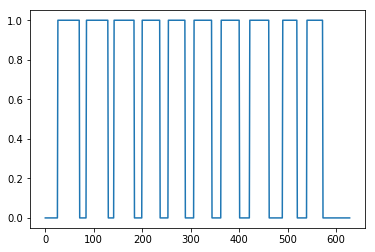

In [769]:
plt.plot(pred_label)
plt.show()

In [116]:
psuedo_pred_label = np.ones(len(test_img_files))
psuedo_pred_label[test_mask] = pred_label

NameError: name 'test_img_files' is not defined

In [118]:
movie_bases

['IMG_7471',
 'IMG_7470',
 'VID_20171128_174622',
 'VID_20171128_174702',
 'IMG_4936',
 'IMG_4937']

In [119]:
bk_movie_names = [[] for _ in movie_bases]

for mn in nm_movie_names:
    flag = False
    for i, mb in enumerate(movie_bases):
        if mb in mn:
            bk_movie_names[i].append(mn)
            flag = True
            break
    if not flag:
        print(mn)

In [120]:
imgs_pardir = "../data/movie_push-ups-from-side/2-3.COCO-pict-mini/"

test_movie_names = movie_names[train_max_index:]
test_img_files = []
for mn in test_movie_names:
    filename = mn[:mn.index(".")]
    test_img_files.append(imgs_pardir + filename + "/" + mn)

In [121]:
len(test_img_files)

4617

In [129]:
def genText(mask, pred_label, frame):
    text = ("%04d: " % frame) + ("UP" if pred_label[frame] == 1 else "DOWN")
    color = "red" if mask[frame] else "blue"
    return text, color

<IPython.core.display.Javascript object>


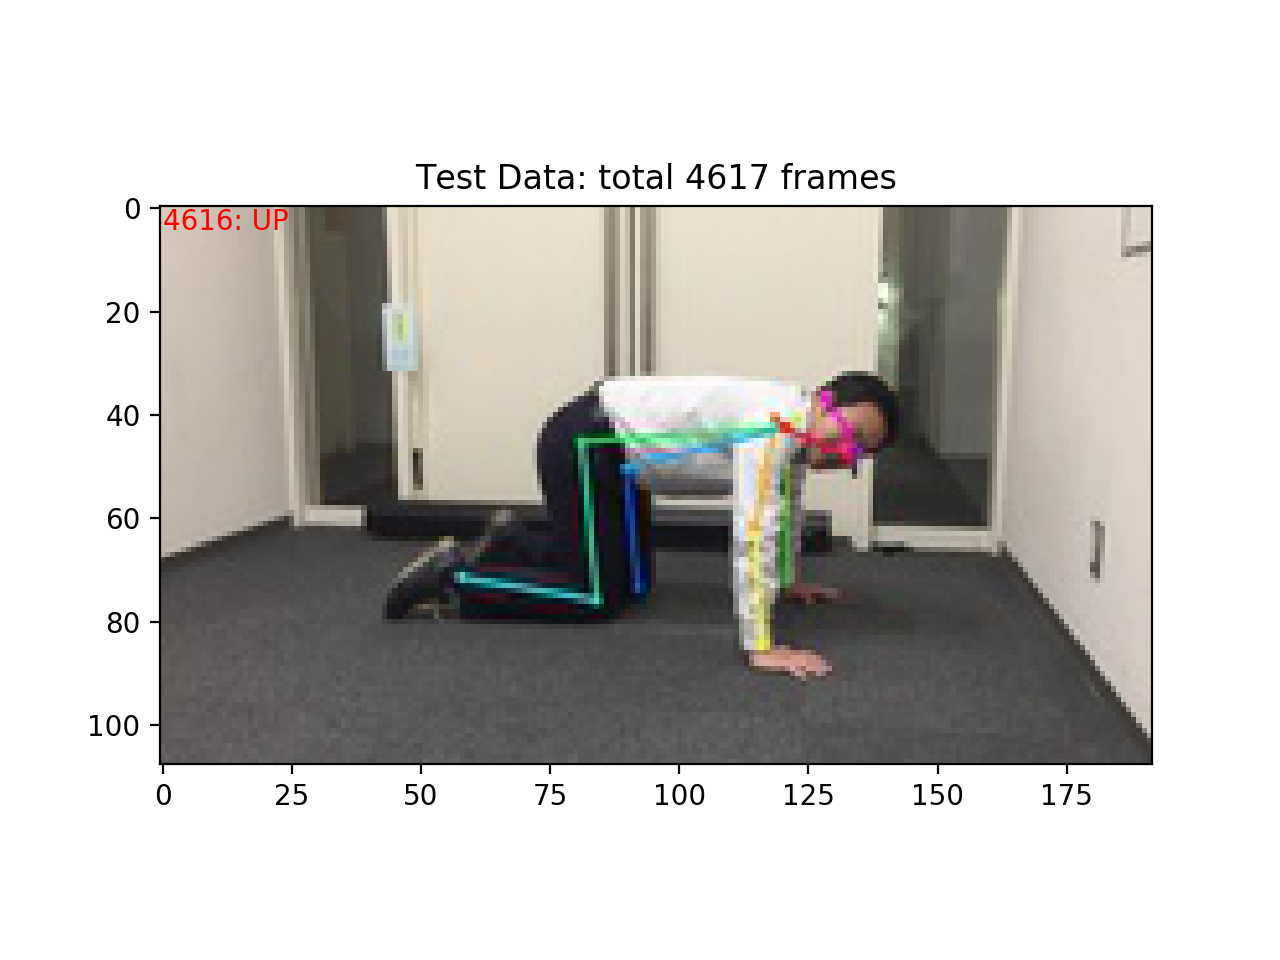

In [130]:
# topleft text indicates...
# 4-digit-number: frame number
# 

%matplotlib nbagg

fig = plt.figure()
plt.title("Test Data: total %d frames" % len(test_img_files))
ims = []

for i, img_file in enumerate(test_img_files):
    img = plt.imread(img_file)
    t, c = genText(test_mask, psuedo_pred_label, i)
    ims.append([plt.imshow(img), plt.text(0, 0, t, ha="left", va="top", color=c)])
    
ani = animation.ArtistAnimation(fig, ims, interval=33, repeat=True)
# ani.save("supervised.mp4", writer="ffmpeg")
plt.show()